# Setup
Importing files and importing libraries

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'2.5.0'

In [2]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

## Notes to self:
1. Images are in folder 'patch_images'

2. Dataset has the following columns: InstanceID, patientID, ImageName, cellTypeName, cellType, isCancerous
- data_labels_mainData.csv - has all the columns stated above
- data_labels_extraData.csv - does not have cellTypeName & cellType

Not sure how to deal with the extra dataset so I'll just use the main one first

In [3]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data_labels_mainData.csv')

train_data_big, test_data_big = train_test_split(data, test_size=0.2, random_state=42)
train_data_big, val_data_big = train_test_split(train_data_big, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_big.shape[0], val_data_big.shape[0], test_data_big.shape[0]))
data.head()

Train data : 5937, Val Data: 1979, Test Data: 1980


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


Making the datasets smaller for faster processing speed (for now)

In [4]:
from sklearn.model_selection import train_test_split

_, train_data = train_test_split(train_data_big, test_size=0.1, random_state=42)
_, test_data = train_test_split(test_data_big, test_size=0.1, random_state=42)
_, val_data = train_test_split(val_data_big, test_size=0.1, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 594, Val Data: 198, Test Data: 198


# EDA
Definitely need to add more EDA

In [5]:
train_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
7873,5525,50,5525.png,epithelial,2,1
2790,8712,17,8712.png,epithelial,2,1
1828,13580,10,13580.png,epithelial,2,1
2370,3083,14,3083.png,epithelial,2,1
6048,20513,37,20513.png,fibroblast,0,0


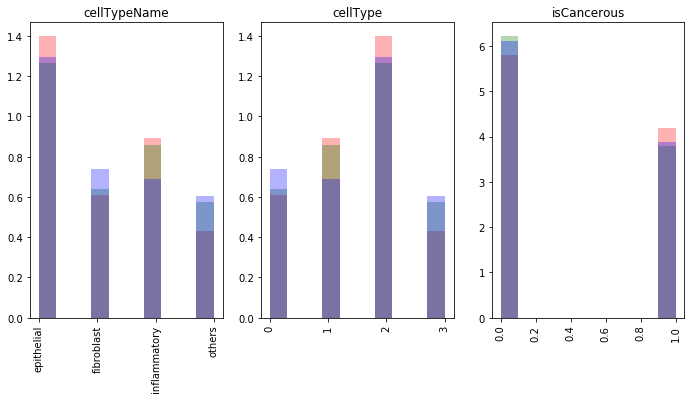

In [6]:
# plt.figure(figsize=(20,20))
# for i, col in enumerate(train_data.columns):
#     plt.subplot(4,5,i+1)
#     _, bins, _ = plt.hist(train_data[col], alpha=0.3, color='r', density=True)
#     _, bins2, _ = plt.hist(test_data[col], bins=bins, alpha=0.3, color='g', density=True)
#     plt.hist(val_data[col], bins=bins2, alpha=0.3, color='b', density=True)
#     plt.title(col)
#     plt.xticks(rotation='vertical')

plt.figure(figsize=(20,25))
for i, col in enumerate(['cellTypeName','cellType', 'isCancerous']):
    plt.subplot(4,5,i+1)
    _, bins, _ = plt.hist(train_data[col], alpha=0.3, color='r', density=True)
    _, bins2, _ = plt.hist(test_data[col], bins=bins, alpha=0.3, color='g', density=True)
    plt.hist(val_data[col], bins=bins2, alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

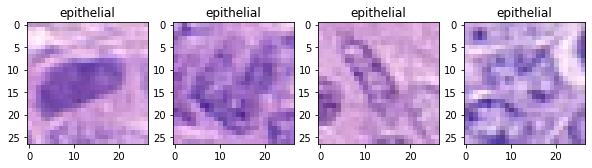

In [7]:
from PIL import Image

label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/'+train_data['ImageName'])
target = train_data['cellType']
target_list = list(target)

fig = plt.figure(figsize=[10,10])

for i in np.arange(4):
    plt.subplot(1, 4, i+1)
    img = Image.open(img_list[i])
    
    plt.imshow(img)
    plt.title(d_inv[int(target_list[i])])

In [8]:
# check image size

img = Image.open(img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH:{} W:{} C:{}'.format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size 
H:27 W:27 C:3


# Model Development
Our assignment has 2 parts:
- Classify images according to whether given cell image represents a cancerous cellsor not (isCancerous).
- Classify images according to cell-type, such as: fibroblast,inflammatory,epithelial or others.

I'll start with the 2nd point first - Classify images according to cell-type

### Initializing the model

In [9]:
# learning curve function
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Mock Base Model
Just playing around, based on week 9 QnA + Lab (both pretty much the same)

In [73]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [74]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


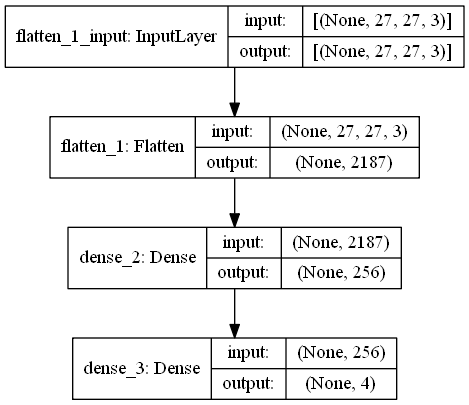

In [76]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [77]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

### Training the Model

In [13]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 4 classes.
Found 198 validated image filenames belonging to 4 classes.


In [80]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

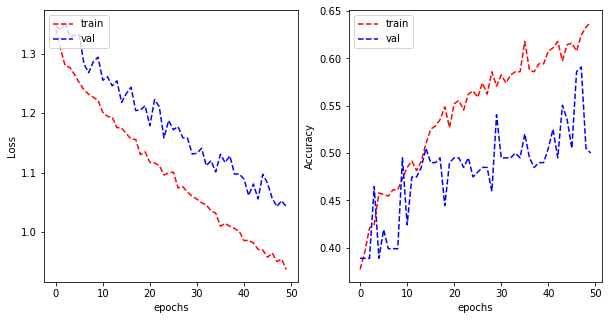

In [81]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Parameters Tuning for base model
### Regularization
Tuning the lambda value for l2 regulurization

In [82]:
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [83]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [84]:
history_reg = model_reg.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

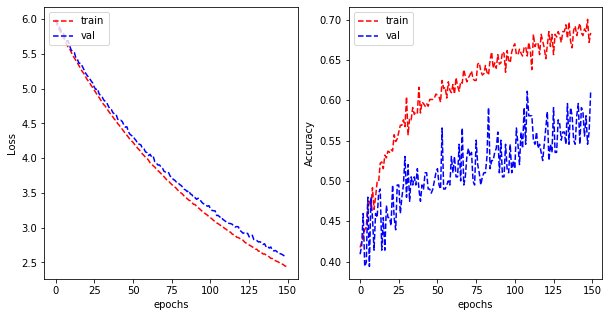

In [85]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Dropout

In [86]:
reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [87]:
model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [88]:
history_drop = model_drop.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

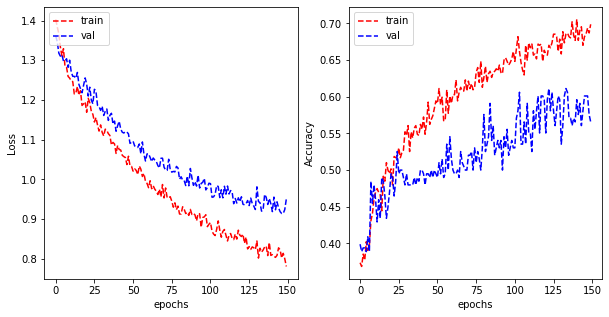

In [89]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Using keras-tuner to tune the model

In [90]:
!pip install -q -U keras-tuner

You should consider upgrading via the 'c:\users\pc\anaconda3\python.exe -m pip install --upgrade pip' command.


In [91]:
import kerastuner as kt

In [92]:
from tensorflow import keras
from tensorflow.keras import layers

INPUT_DIM = (27,27,3)
# We will be tuning HIDDEN_LAYER_DIM as hp_units
# HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

# copy pasted from https://www.tensorflow.org/tutorials/keras/keras_tuner, will need to paraphrase
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=INPUT_DIM))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(OUTPUT_CLASSES))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])



  return model

In [93]:
# Instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

### Saving the models created

In [94]:
# Original model without tuning
model.save("base_model")

# Model with regularization
model_reg.save("reg_base_model")

# Model with dropout
model_drop.save("dropout_base_model")

INFO:tensorflow:Assets written to: base_model\assets
INFO:tensorflow:Assets written to: reg_base_model\assets
INFO:tensorflow:Assets written to: dropout_base_model\assets


## Testing the final model
The model tuning by dropout seems to have the best performance

In [95]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 198 validated image filenames belonging to 4 classes.


C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
model_drop.evaluate(test_generator)

198/198 [==============================] - 0s 1ms/step - loss: 0.9231 - categorical_accuracy: 0.6313


[0.9231238961219788, 0.631313145160675]

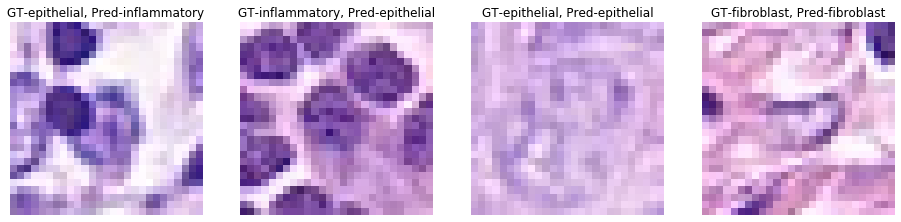

In [97]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

# Mock 2nd Model (leNet)
Based on week 10 QnA (week 10 lab uses VGG)

In [98]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 4 classes.
Found 198 validated image filenames belonging to 4 classes.


In [99]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [100]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_leNet.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet.fit(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=100, verbose=0)

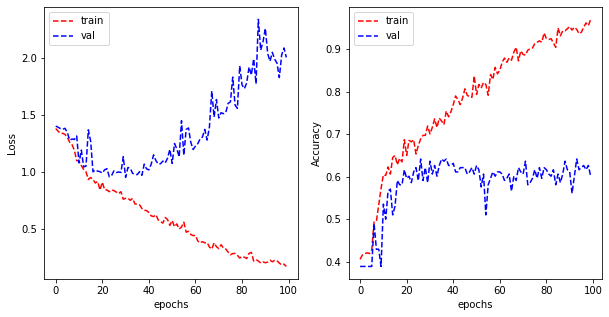

In [101]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Data Augmentation/Tuning for leNet model
TODO

# Mock 3rd Model (VGG)
Based on week 10 lab

In [102]:
import tensorflow as tf

OUTPUT_CLASSES = 4
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [103]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [104]:
history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

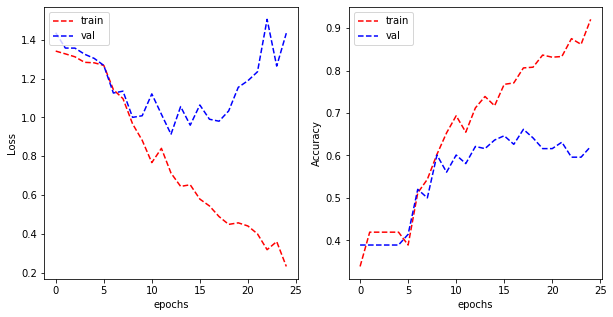

In [105]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Data Augmentation/Tuning for VGG model
TODO

# Model Development part 2
Our assignment has 2 parts:
- Classify images according to whether given cell image represents a cancerous cellsor not (isCancerous).
- Classify images according to cell-type, such as: fibroblast,inflammatory,epithelial or others.

Now I'll do the detecting cancerous cell of the assignment

### EDA

In [106]:
train_data.cellTypeName.unique()

array(['epithelial', 'fibroblast', 'inflammatory', 'others'], dtype=object)

Since there is 4 cell type and 2 isCancerous type, the number of label that one model has to predict is 8. It is better to have 4 models and each model handling 1 cell type and 2 isCancerous type and predict 2 label than having one model predict 8. 

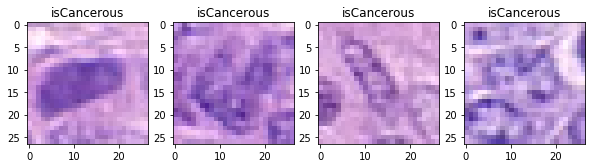

In [107]:
from PIL import Image

label_names = {'isCancerous' : 1, 'notCancerous' : 0}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/'+train_data['ImageName'])
target = train_data['isCancerous']
target_list = list(target)

fig = plt.figure(figsize=[10,10])
n = 4
for i in np.arange(n):
    plt.subplot(1, n, i+1)
    img = Image.open(img_list[i])
    
    plt.imshow(img)
    plt.title(d_inv[int(target_list[i])])

An interesting revalation occur, apparently cell type fibroblast, inflammatory and other does not have isCancerous lable while cell type epithelial does not have notCancerous label. 

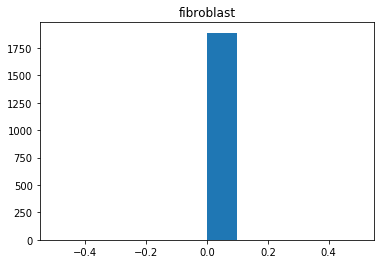

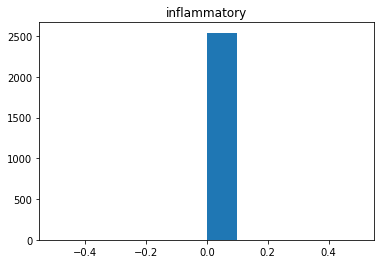

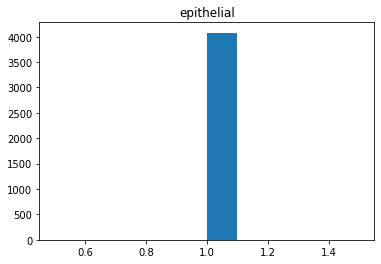

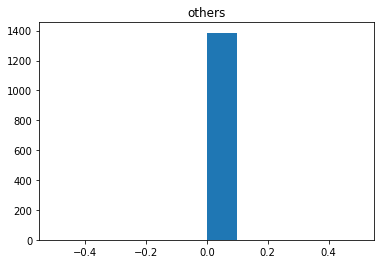

In [108]:

fibroblast = data[data['cellType']==0]
inflammatory = data[data['cellType']==1]
epithelial = data[data['cellType']==2]
others = data[data['cellType']==3]


plt.hist(fibroblast['isCancerous'])
plt.title('fibroblast')
plt.show()

plt.hist(inflammatory['isCancerous'])
plt.title('inflammatory')
plt.show()

plt.hist(epithelial['isCancerous'])
plt.title('epithelial')
plt.show()

plt.hist(others['isCancerous'])
plt.title('others')
plt.show()

From the observation above, it would not be smart to have 4 models handling each type of cell. Sorry if this contracdict with what I said above but I tried to avoid a "Zero Frequency Probem"

In [109]:
"""
train_data_fibroblast = train_data[train_data['cellType']=='0']
train_data_inflammatory = train_data[train_data['cellType']=='1']
train_data_epithelial = train_data[train_data['cellType']=='2']
train_data_others = train_data[train_data['cellType']=='3']

test_data_fibroblast = test_data[test_data['cellType']=='0']
test_data_inflammatory = test_data[test_data['cellType']=='1']
test_data_epithelial = test_data[test_data['cellType']=='2']
test_data_others = test_data[test_data['cellType']=='3']

val_data_fibroblast = val_data[val_data['cellType']=='0']
val_data_inflammatory = val_data[val_data['cellType']=='1']
val_data_epithelial = val_data[val_data['cellType']=='2']
val_data_others = val_data[val_data['cellType']=='3']
"""

"\ntrain_data_fibroblast = train_data[train_data['cellType']=='0']\ntrain_data_inflammatory = train_data[train_data['cellType']=='1']\ntrain_data_epithelial = train_data[train_data['cellType']=='2']\ntrain_data_others = train_data[train_data['cellType']=='3']\n\ntest_data_fibroblast = test_data[test_data['cellType']=='0']\ntest_data_inflammatory = test_data[test_data['cellType']=='1']\ntest_data_epithelial = test_data[test_data['cellType']=='2']\ntest_data_others = test_data[test_data['cellType']=='3']\n\nval_data_fibroblast = val_data[val_data['cellType']=='0']\nval_data_inflammatory = val_data[val_data['cellType']=='1']\nval_data_epithelial = val_data[val_data['cellType']=='2']\nval_data_others = val_data[val_data['cellType']=='3']\n"

### Training the model

In [110]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [111]:
model_cancer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])


In [112]:
model_cancer.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [17]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [114]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.


In [115]:
history = model_cancer.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

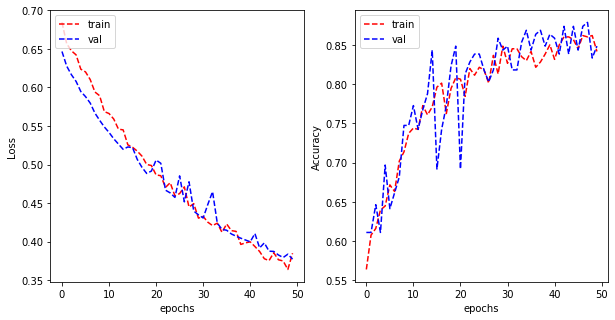

In [116]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Parameters Tuning for base model
### Regularization
Tuning the lambda value for l2 regulurization

In [117]:
reg_lambda = 0.02

model_cancer_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [118]:
model_cancer_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [119]:
history_cancer_reg = model_cancer_reg.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

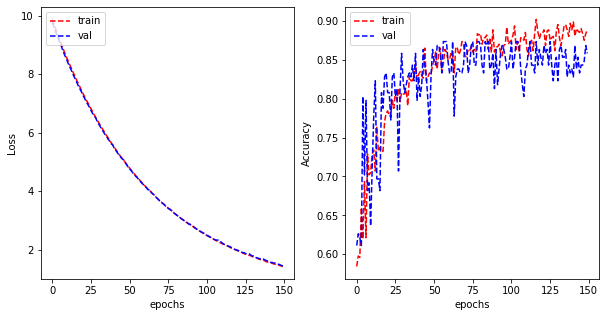

In [120]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_cancer_reg.history['loss'], 'r--')
plt.plot(history_cancer_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_cancer_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_cancer_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Drop out

In [121]:
reg_lambda = 0.02

model_cancer_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [122]:
model_cancer_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [123]:
history_cancer_drop = model_cancer_drop.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

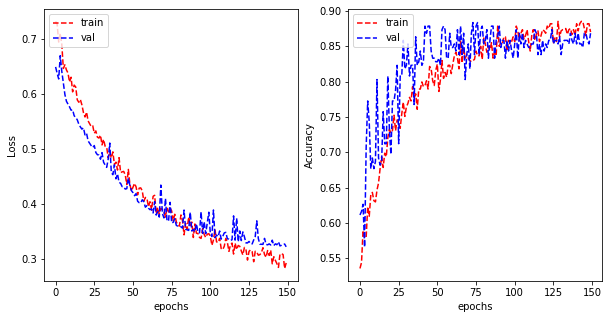

In [124]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_cancer_drop.history['loss'], 'r--')
plt.plot(history_cancer_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_cancer_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_cancer_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

## Cross validation to train the model

In [125]:
from sklearn.model_selection import KFold, StratifiedKFold

In [126]:
Y = train_data[['isCancerous']]
kf = KFold(n_splits = 10)
Y

,isCancerous
7873,1
2790,1
1828,1
2370,1
6048,0
...,...
4491,0
9667,0
140,0
6924,0


In [127]:
idg = ImageDataGenerator(rescale=1./255, data_format='channels_last')

In [128]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [129]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/cancer_CV/'
fold_var = 1
reg_lambda = 0.02

for train_index, val_index in kf.split(Y):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
    
    train_datagen = idg.flow_from_dataframe(dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
    valid_datagen  = idg.flow_from_dataframe(dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
       


    # CREATE NEW MODEL
    model_cancer_CV = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
    # COMPILE NEW MODEL
    model_cancer_CV.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history_CV = model_cancer_CV.fit(train_datagen,
                epochs=200,
                callbacks=callbacks_list,
                validation_data= valid_datagen,
                verbose=1)
    #PLOT HISTORY
    #       :
    #       :

    # LOAD BEST MODEL to evaluate the performance of the model
   
    model_cancer_CV.load_weights("/cancer_CV/model_"+str(fold_var)+".h5")

    results = model_cancer_CV.evaluate(valid_datagen)
    results = dict(zip(model_cancer_CV.metrics_names,results))

    VALIDATION_ACCURACY.append(results['categorical_accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1



Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.
Epoch 1/200
19/19 [==============================] - 1s 23ms/step - loss: 9.8997 - categorical_accuracy: 0.5354 - val_loss: 9.7756 - val_categorical_accuracy: 0.6111
Epoch 2/200
19/19 [==============================] - 0s 17ms/step - loss: 9.7267 - categorical_accuracy: 0.5623 - val_loss: 9.6196 - val_categorical_accuracy: 0.6111
Epoch 3/200
19/19 [==============================] - 0s 17ms/step - loss: 9.5890 - categorical_accuracy: 0.5522 - val_loss: 9.4743 - val_categorical_accuracy: 0.6111
Epoch 4/200
19/19 [==============================] - 0s 17ms/step - loss: 9.4325 - categorical_accuracy: 0.5875 - val_loss: 9.3281 - val_categorical_accuracy: 0.6111
Epoch 5/200
19/19 [==============================] - 0s 17ms/step - loss: 9.2889 - categorical_accuracy: 0.6279 - val_loss: 9.1852 - val_categorical_accuracy: 0.6111
Epoch 6/200
19/19 [==============================]

Epoch 66/200
19/19 [==============================] - 0s 17ms/step - loss: 3.8918 - categorical_accuracy: 0.8502 - val_loss: 3.8738 - val_categorical_accuracy: 0.8687
Epoch 67/200
19/19 [==============================] - 0s 17ms/step - loss: 3.8418 - categorical_accuracy: 0.8401 - val_loss: 3.8499 - val_categorical_accuracy: 0.8434
Epoch 68/200
19/19 [==============================] - 0s 17ms/step - loss: 3.7888 - categorical_accuracy: 0.8620 - val_loss: 3.7804 - val_categorical_accuracy: 0.8384
Epoch 69/200
19/19 [==============================] - 0s 17ms/step - loss: 3.7352 - categorical_accuracy: 0.8603 - val_loss: 3.7228 - val_categorical_accuracy: 0.8687
Epoch 70/200
19/19 [==============================] - 0s 17ms/step - loss: 3.6837 - categorical_accuracy: 0.8721 - val_loss: 3.6742 - val_categorical_accuracy: 0.8687
Epoch 71/200
19/19 [==============================] - 0s 17ms/step - loss: 3.6357 - categorical_accuracy: 0.8754 - val_loss: 3.6492 - val_categorical_accuracy: 0.853

Epoch 99/200
19/19 [==============================] - 0s 17ms/step - loss: 2.5269 - categorical_accuracy: 0.8906 - val_loss: 2.5395 - val_categorical_accuracy: 0.8737
Epoch 100/200
19/19 [==============================] - 0s 17ms/step - loss: 2.5065 - categorical_accuracy: 0.8721 - val_loss: 2.5421 - val_categorical_accuracy: 0.8384
Epoch 101/200
19/19 [==============================] - 0s 17ms/step - loss: 2.4650 - categorical_accuracy: 0.8788 - val_loss: 2.4870 - val_categorical_accuracy: 0.8434
Epoch 102/200
19/19 [==============================] - 0s 17ms/step - loss: 2.4467 - categorical_accuracy: 0.8653 - val_loss: 2.4485 - val_categorical_accuracy: 0.8586
Epoch 103/200
19/19 [==============================] - 0s 17ms/step - loss: 2.4200 - categorical_accuracy: 0.8704 - val_loss: 2.4313 - val_categorical_accuracy: 0.8434
Epoch 104/200
19/19 [==============================] - 0s 17ms/step - loss: 2.3836 - categorical_accuracy: 0.8771 - val_loss: 2.3934 - val_categorical_accuracy: 

Epoch 132/200
19/19 [==============================] - 0s 17ms/step - loss: 1.7103 - categorical_accuracy: 0.8973 - val_loss: 1.7359 - val_categorical_accuracy: 0.8535
Epoch 133/200
19/19 [==============================] - 0s 17ms/step - loss: 1.6914 - categorical_accuracy: 0.8973 - val_loss: 1.7175 - val_categorical_accuracy: 0.8535
Epoch 134/200
19/19 [==============================] - 0s 17ms/step - loss: 1.6884 - categorical_accuracy: 0.8771 - val_loss: 1.6974 - val_categorical_accuracy: 0.8636
Epoch 135/200
19/19 [==============================] - 0s 17ms/step - loss: 1.6651 - categorical_accuracy: 0.8838 - val_loss: 1.6805 - val_categorical_accuracy: 0.8687
Epoch 136/200
19/19 [==============================] - 0s 17ms/step - loss: 1.6484 - categorical_accuracy: 0.8923 - val_loss: 1.6613 - val_categorical_accuracy: 0.8636
Epoch 137/200
19/19 [==============================] - 0s 17ms/step - loss: 1.6280 - categorical_accuracy: 0.8923 - val_loss: 1.6619 - val_categorical_accuracy:

Epoch 197/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9340 - categorical_accuracy: 0.8788 - val_loss: 0.9625 - val_categorical_accuracy: 0.8687
Epoch 198/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9352 - categorical_accuracy: 0.8838 - val_loss: 0.9684 - val_categorical_accuracy: 0.8485
Epoch 199/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9180 - categorical_accuracy: 0.8906 - val_loss: 0.9523 - val_categorical_accuracy: 0.8636
Epoch 200/200
7/7 [==============================] - 0s 10ms/step - loss: 9.8548 - categorical_accuracy: 0.8535
Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.
Epoch 1/200
19/19 [==============================] - 1s 23ms/step - loss: 9.8606 - categorical_accuracy: 0.5556 - val_loss: 9.7516 - val_categorical_accuracy: 0.6111
Epoch 2/200
19/19 [==============================] - 0s 17ms/step - loss: 9.7128 - categorical_acc

Epoch 29/200
19/19 [==============================] - 0s 17ms/step - loss: 6.5239 - categorical_accuracy: 0.8013 - val_loss: 6.4622 - val_categorical_accuracy: 0.7980
Epoch 30/200
19/19 [==============================] - 0s 17ms/step - loss: 6.4265 - categorical_accuracy: 0.8030 - val_loss: 6.3720 - val_categorical_accuracy: 0.8030
Epoch 31/200
19/19 [==============================] - 0s 17ms/step - loss: 6.3308 - categorical_accuracy: 0.8047 - val_loss: 6.3024 - val_categorical_accuracy: 0.8283
Epoch 32/200
19/19 [==============================] - 0s 17ms/step - loss: 6.2395 - categorical_accuracy: 0.8451 - val_loss: 6.1922 - val_categorical_accuracy: 0.8283
Epoch 33/200
19/19 [==============================] - 0s 17ms/step - loss: 6.1557 - categorical_accuracy: 0.8114 - val_loss: 6.1057 - val_categorical_accuracy: 0.8081
Epoch 34/200
19/19 [==============================] - 0s 17ms/step - loss: 6.0689 - categorical_accuracy: 0.8182 - val_loss: 6.0191 - val_categorical_accuracy: 0.833

Epoch 62/200
19/19 [==============================] - 0s 17ms/step - loss: 4.1050 - categorical_accuracy: 0.8653 - val_loss: 4.0894 - val_categorical_accuracy: 0.8485
Epoch 63/200
19/19 [==============================] - 0s 17ms/step - loss: 4.0514 - categorical_accuracy: 0.8805 - val_loss: 4.0351 - val_categorical_accuracy: 0.8485
Epoch 64/200
19/19 [==============================] - 0s 18ms/step - loss: 3.9989 - categorical_accuracy: 0.8552 - val_loss: 3.9897 - val_categorical_accuracy: 0.8333
Epoch 65/200
19/19 [==============================] - 0s 17ms/step - loss: 3.9473 - categorical_accuracy: 0.8603 - val_loss: 3.9593 - val_categorical_accuracy: 0.8384
Epoch 66/200
19/19 [==============================] - 0s 17ms/step - loss: 3.8915 - categorical_accuracy: 0.8569 - val_loss: 3.8821 - val_categorical_accuracy: 0.8434
Epoch 67/200
19/19 [==============================] - 0s 18ms/step - loss: 3.8384 - categorical_accuracy: 0.8687 - val_loss: 3.8543 - val_categorical_accuracy: 0.838

Epoch 95/200
19/19 [==============================] - 0s 17ms/step - loss: 2.6694 - categorical_accuracy: 0.8906 - val_loss: 2.7001 - val_categorical_accuracy: 0.8384
Epoch 96/200
19/19 [==============================] - 0s 17ms/step - loss: 2.6332 - categorical_accuracy: 0.8721 - val_loss: 2.6334 - val_categorical_accuracy: 0.8838
Epoch 97/200
19/19 [==============================] - 0s 17ms/step - loss: 2.5951 - categorical_accuracy: 0.8788 - val_loss: 2.6056 - val_categorical_accuracy: 0.8434
Epoch 98/200
19/19 [==============================] - 0s 17ms/step - loss: 2.5671 - categorical_accuracy: 0.8737 - val_loss: 2.5694 - val_categorical_accuracy: 0.8737
Epoch 99/200
19/19 [==============================] - 0s 17ms/step - loss: 2.5289 - categorical_accuracy: 0.8906 - val_loss: 2.5378 - val_categorical_accuracy: 0.8838
Epoch 100/200
19/19 [==============================] - 0s 17ms/step - loss: 2.5093 - categorical_accuracy: 0.8721 - val_loss: 2.5072 - val_categorical_accuracy: 0.87

Epoch 128/200
19/19 [==============================] - 0s 17ms/step - loss: 1.7998 - categorical_accuracy: 0.8923 - val_loss: 1.8201 - val_categorical_accuracy: 0.8434
Epoch 129/200
19/19 [==============================] - 0s 17ms/step - loss: 1.7717 - categorical_accuracy: 0.8872 - val_loss: 1.7920 - val_categorical_accuracy: 0.8586
Epoch 130/200
19/19 [==============================] - 0s 17ms/step - loss: 1.7688 - categorical_accuracy: 0.8771 - val_loss: 1.8187 - val_categorical_accuracy: 0.8283
Epoch 131/200
19/19 [==============================] - 0s 17ms/step - loss: 1.7358 - categorical_accuracy: 0.8939 - val_loss: 1.7528 - val_categorical_accuracy: 0.8586
Epoch 132/200
19/19 [==============================] - 0s 17ms/step - loss: 1.7151 - categorical_accuracy: 0.8872 - val_loss: 1.7340 - val_categorical_accuracy: 0.8586
Epoch 133/200
19/19 [==============================] - 0s 17ms/step - loss: 1.6990 - categorical_accuracy: 0.8923 - val_loss: 1.7183 - val_categorical_accuracy:

Epoch 193/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9586 - categorical_accuracy: 0.8990 - val_loss: 0.9908 - val_categorical_accuracy: 0.8636
Epoch 194/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9496 - categorical_accuracy: 0.8923 - val_loss: 0.9991 - val_categorical_accuracy: 0.8333
Epoch 195/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9457 - categorical_accuracy: 0.8956 - val_loss: 0.9792 - val_categorical_accuracy: 0.8687
Epoch 196/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9378 - categorical_accuracy: 0.8923 - val_loss: 0.9699 - val_categorical_accuracy: 0.8586
Epoch 197/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9315 - categorical_accuracy: 0.8906 - val_loss: 0.9616 - val_categorical_accuracy: 0.8586
Epoch 198/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9293 - categorical_accuracy: 0.8822 - val_loss: 0.9700 - val_categorical_accuracy:

Epoch 25/200
19/19 [==============================] - 0s 17ms/step - loss: 6.8844 - categorical_accuracy: 0.8232 - val_loss: 6.8368 - val_categorical_accuracy: 0.8586
Epoch 26/200
19/19 [==============================] - 0s 18ms/step - loss: 6.7843 - categorical_accuracy: 0.8148 - val_loss: 6.7330 - val_categorical_accuracy: 0.8131
Epoch 27/200
19/19 [==============================] - 0s 17ms/step - loss: 6.6939 - categorical_accuracy: 0.8064 - val_loss: 6.6368 - val_categorical_accuracy: 0.8081
Epoch 28/200
19/19 [==============================] - 0s 17ms/step - loss: 6.5998 - categorical_accuracy: 0.7997 - val_loss: 6.5572 - val_categorical_accuracy: 0.8586
Epoch 29/200
19/19 [==============================] - 0s 17ms/step - loss: 6.5032 - categorical_accuracy: 0.8098 - val_loss: 6.4797 - val_categorical_accuracy: 0.8131
Epoch 30/200
19/19 [==============================] - 0s 17ms/step - loss: 6.4097 - categorical_accuracy: 0.8131 - val_loss: 6.3880 - val_categorical_accuracy: 0.813

Epoch 58/200
19/19 [==============================] - 0s 17ms/step - loss: 4.3309 - categorical_accuracy: 0.8586 - val_loss: 4.3128 - val_categorical_accuracy: 0.8232
Epoch 59/200
19/19 [==============================] - 0s 17ms/step - loss: 4.2685 - categorical_accuracy: 0.8451 - val_loss: 4.2676 - val_categorical_accuracy: 0.8485
Epoch 60/200
19/19 [==============================] - 0s 17ms/step - loss: 4.2092 - categorical_accuracy: 0.8653 - val_loss: 4.2058 - val_categorical_accuracy: 0.8434
Epoch 61/200
19/19 [==============================] - 0s 17ms/step - loss: 4.1529 - categorical_accuracy: 0.8535 - val_loss: 4.1496 - val_categorical_accuracy: 0.8434
Epoch 62/200
19/19 [==============================] - 0s 17ms/step - loss: 4.0981 - categorical_accuracy: 0.8670 - val_loss: 4.0895 - val_categorical_accuracy: 0.8434
Epoch 63/200
19/19 [==============================] - 0s 17ms/step - loss: 4.0464 - categorical_accuracy: 0.8569 - val_loss: 4.0479 - val_categorical_accuracy: 0.858

Epoch 91/200
19/19 [==============================] - 0s 17ms/step - loss: 2.8015 - categorical_accuracy: 0.8670 - val_loss: 2.8150 - val_categorical_accuracy: 0.8535
Epoch 92/200
19/19 [==============================] - 0s 17ms/step - loss: 2.7692 - categorical_accuracy: 0.8636 - val_loss: 2.7665 - val_categorical_accuracy: 0.8687
Epoch 93/200
19/19 [==============================] - 0s 17ms/step - loss: 2.7264 - categorical_accuracy: 0.8788 - val_loss: 2.7296 - val_categorical_accuracy: 0.8687
Epoch 94/200
19/19 [==============================] - 0s 17ms/step - loss: 2.6930 - categorical_accuracy: 0.8687 - val_loss: 2.6988 - val_categorical_accuracy: 0.8687
Epoch 95/200
19/19 [==============================] - 0s 17ms/step - loss: 2.6633 - categorical_accuracy: 0.8788 - val_loss: 2.6629 - val_categorical_accuracy: 0.8687
Epoch 96/200
19/19 [==============================] - 0s 17ms/step - loss: 2.6283 - categorical_accuracy: 0.8788 - val_loss: 2.6579 - val_categorical_accuracy: 0.813

Epoch 124/200
19/19 [==============================] - 0s 17ms/step - loss: 1.8761 - categorical_accuracy: 0.8889 - val_loss: 1.8911 - val_categorical_accuracy: 0.8636
Epoch 125/200
19/19 [==============================] - 0s 17ms/step - loss: 1.8645 - categorical_accuracy: 0.8771 - val_loss: 1.8704 - val_categorical_accuracy: 0.8586
Epoch 126/200
19/19 [==============================] - 0s 17ms/step - loss: 1.8344 - categorical_accuracy: 0.8721 - val_loss: 1.8514 - val_categorical_accuracy: 0.8737
Epoch 127/200
19/19 [==============================] - 0s 17ms/step - loss: 1.8105 - categorical_accuracy: 0.8990 - val_loss: 1.8482 - val_categorical_accuracy: 0.8485
Epoch 128/200
19/19 [==============================] - 0s 18ms/step - loss: 1.7914 - categorical_accuracy: 0.8889 - val_loss: 1.8228 - val_categorical_accuracy: 0.8434
Epoch 129/200
19/19 [==============================] - 0s 18ms/step - loss: 1.7696 - categorical_accuracy: 0.8939 - val_loss: 1.7904 - val_categorical_accuracy:

Epoch 157/200
19/19 [==============================] - 0s 18ms/step - loss: 1.3195 - categorical_accuracy: 0.8855 - val_loss: 1.3454 - val_categorical_accuracy: 0.8636
Epoch 158/200
19/19 [==============================] - 0s 17ms/step - loss: 1.3077 - categorical_accuracy: 0.8923 - val_loss: 1.3364 - val_categorical_accuracy: 0.8586
Epoch 159/200
19/19 [==============================] - 0s 17ms/step - loss: 1.2857 - categorical_accuracy: 0.8973 - val_loss: 1.3376 - val_categorical_accuracy: 0.8434
Epoch 160/200
19/19 [==============================] - 0s 17ms/step - loss: 1.2845 - categorical_accuracy: 0.8788 - val_loss: 1.3075 - val_categorical_accuracy: 0.8636
Epoch 161/200
19/19 [==============================] - 0s 17ms/step - loss: 1.2655 - categorical_accuracy: 0.8973 - val_loss: 1.3511 - val_categorical_accuracy: 0.8131
Epoch 162/200
19/19 [==============================] - 0s 17ms/step - loss: 1.2648 - categorical_accuracy: 0.8956 - val_loss: 1.2907 - val_categorical_accuracy:

Epoch 21/200
19/19 [==============================] - 0s 18ms/step - loss: 7.3157 - categorical_accuracy: 0.7660 - val_loss: 7.2497 - val_categorical_accuracy: 0.8232
Epoch 22/200
19/19 [==============================] - 0s 19ms/step - loss: 7.2055 - categorical_accuracy: 0.7912 - val_loss: 7.1439 - val_categorical_accuracy: 0.7424
Epoch 23/200
19/19 [==============================] - 0s 18ms/step - loss: 7.0988 - categorical_accuracy: 0.7912 - val_loss: 7.0456 - val_categorical_accuracy: 0.7172
Epoch 24/200
19/19 [==============================] - 0s 18ms/step - loss: 6.9984 - categorical_accuracy: 0.7710 - val_loss: 6.9443 - val_categorical_accuracy: 0.8283
Epoch 25/200
19/19 [==============================] - 0s 19ms/step - loss: 6.9061 - categorical_accuracy: 0.7778 - val_loss: 6.8466 - val_categorical_accuracy: 0.8434
Epoch 26/200
19/19 [==============================] - 0s 17ms/step - loss: 6.8022 - categorical_accuracy: 0.7946 - val_loss: 6.7461 - val_categorical_accuracy: 0.838

Epoch 54/200
19/19 [==============================] - 0s 17ms/step - loss: 4.5786 - categorical_accuracy: 0.8519 - val_loss: 4.5526 - val_categorical_accuracy: 0.8838
Epoch 55/200
19/19 [==============================] - 0s 18ms/step - loss: 4.5139 - categorical_accuracy: 0.8502 - val_loss: 4.4913 - val_categorical_accuracy: 0.8939
Epoch 56/200
19/19 [==============================] - 0s 17ms/step - loss: 4.4536 - categorical_accuracy: 0.8418 - val_loss: 4.4479 - val_categorical_accuracy: 0.8333
Epoch 57/200
19/19 [==============================] - 0s 18ms/step - loss: 4.3917 - categorical_accuracy: 0.8502 - val_loss: 4.3919 - val_categorical_accuracy: 0.8333
Epoch 58/200
19/19 [==============================] - 0s 18ms/step - loss: 4.3408 - categorical_accuracy: 0.8434 - val_loss: 4.3227 - val_categorical_accuracy: 0.8333
Epoch 59/200
19/19 [==============================] - 0s 18ms/step - loss: 4.2832 - categorical_accuracy: 0.8367 - val_loss: 4.2910 - val_categorical_accuracy: 0.813

Epoch 87/200
19/19 [==============================] - 0s 18ms/step - loss: 2.9459 - categorical_accuracy: 0.8687 - val_loss: 2.9466 - val_categorical_accuracy: 0.8788
Epoch 88/200
19/19 [==============================] - 0s 19ms/step - loss: 2.9104 - categorical_accuracy: 0.8670 - val_loss: 2.9739 - val_categorical_accuracy: 0.7980
Epoch 89/200
19/19 [==============================] - 0s 18ms/step - loss: 2.8719 - categorical_accuracy: 0.8805 - val_loss: 2.8724 - val_categorical_accuracy: 0.8737
Epoch 90/200
19/19 [==============================] - 0s 18ms/step - loss: 2.8319 - categorical_accuracy: 0.8855 - val_loss: 2.8401 - val_categorical_accuracy: 0.8586
Epoch 91/200
19/19 [==============================] - 0s 18ms/step - loss: 2.8018 - categorical_accuracy: 0.8754 - val_loss: 2.8252 - val_categorical_accuracy: 0.8384
Epoch 92/200
19/19 [==============================] - 0s 18ms/step - loss: 2.7608 - categorical_accuracy: 0.8838 - val_loss: 2.7841 - val_categorical_accuracy: 0.813

Epoch 120/200
19/19 [==============================] - 0s 17ms/step - loss: 1.9667 - categorical_accuracy: 0.8838 - val_loss: 1.9785 - val_categorical_accuracy: 0.8737
Epoch 121/200
19/19 [==============================] - 0s 17ms/step - loss: 1.9411 - categorical_accuracy: 0.8872 - val_loss: 1.9710 - val_categorical_accuracy: 0.8485
Epoch 122/200
19/19 [==============================] - 0s 17ms/step - loss: 1.9181 - categorical_accuracy: 0.8939 - val_loss: 1.9348 - val_categorical_accuracy: 0.8687
Epoch 123/200
19/19 [==============================] - 0s 17ms/step - loss: 1.9138 - categorical_accuracy: 0.8653 - val_loss: 1.9148 - val_categorical_accuracy: 0.8687
Epoch 124/200
19/19 [==============================] - 0s 17ms/step - loss: 1.8872 - categorical_accuracy: 0.8636 - val_loss: 1.8923 - val_categorical_accuracy: 0.8737
Epoch 125/200
19/19 [==============================] - 0s 17ms/step - loss: 1.8612 - categorical_accuracy: 0.8805 - val_loss: 1.8740 - val_categorical_accuracy:

Epoch 153/200
19/19 [==============================] - 0s 17ms/step - loss: 1.3783 - categorical_accuracy: 0.8822 - val_loss: 1.4345 - val_categorical_accuracy: 0.8283
Epoch 154/200
19/19 [==============================] - 0s 17ms/step - loss: 1.3617 - categorical_accuracy: 0.8822 - val_loss: 1.3920 - val_categorical_accuracy: 0.8485
Epoch 155/200
19/19 [==============================] - 0s 18ms/step - loss: 1.3491 - categorical_accuracy: 0.8923 - val_loss: 1.3744 - val_categorical_accuracy: 0.8535
Epoch 156/200
19/19 [==============================] - 0s 17ms/step - loss: 1.3326 - categorical_accuracy: 0.8906 - val_loss: 1.3567 - val_categorical_accuracy: 0.8687
Epoch 157/200
19/19 [==============================] - 0s 17ms/step - loss: 1.3229 - categorical_accuracy: 0.8939 - val_loss: 1.3457 - val_categorical_accuracy: 0.8687
Epoch 158/200
19/19 [==============================] - 0s 18ms/step - loss: 1.3043 - categorical_accuracy: 0.8906 - val_loss: 1.3706 - val_categorical_accuracy:

Epoch 17/200
19/19 [==============================] - 0s 17ms/step - loss: 7.7630 - categorical_accuracy: 0.7357 - val_loss: 7.6958 - val_categorical_accuracy: 0.6818
Epoch 18/200
19/19 [==============================] - 0s 17ms/step - loss: 7.6448 - categorical_accuracy: 0.7542 - val_loss: 7.5779 - val_categorical_accuracy: 0.8081
Epoch 19/200
19/19 [==============================] - 0s 17ms/step - loss: 7.5363 - categorical_accuracy: 0.7593 - val_loss: 7.4685 - val_categorical_accuracy: 0.8081
Epoch 20/200
19/19 [==============================] - 0s 17ms/step - loss: 7.4367 - categorical_accuracy: 0.7424 - val_loss: 7.3598 - val_categorical_accuracy: 0.7525
Epoch 21/200
19/19 [==============================] - 0s 17ms/step - loss: 7.3198 - categorical_accuracy: 0.7694 - val_loss: 7.2551 - val_categorical_accuracy: 0.8081
Epoch 22/200
19/19 [==============================] - 0s 17ms/step - loss: 7.2146 - categorical_accuracy: 0.7744 - val_loss: 7.1501 - val_categorical_accuracy: 0.803

Epoch 50/200
19/19 [==============================] - 0s 18ms/step - loss: 4.8407 - categorical_accuracy: 0.8418 - val_loss: 4.8446 - val_categorical_accuracy: 0.8283
Epoch 51/200
19/19 [==============================] - 0s 18ms/step - loss: 4.7843 - categorical_accuracy: 0.8451 - val_loss: 4.7505 - val_categorical_accuracy: 0.8485
Epoch 52/200
19/19 [==============================] - 0s 17ms/step - loss: 4.7109 - categorical_accuracy: 0.8418 - val_loss: 4.7193 - val_categorical_accuracy: 0.8182
Epoch 53/200
19/19 [==============================] - 0s 17ms/step - loss: 4.6473 - categorical_accuracy: 0.8468 - val_loss: 4.6399 - val_categorical_accuracy: 0.8283
Epoch 54/200
19/19 [==============================] - 0s 18ms/step - loss: 4.5893 - categorical_accuracy: 0.8636 - val_loss: 4.5627 - val_categorical_accuracy: 0.8232
Epoch 55/200
19/19 [==============================] - 0s 17ms/step - loss: 4.5212 - categorical_accuracy: 0.8418 - val_loss: 4.5035 - val_categorical_accuracy: 0.843

Epoch 83/200
19/19 [==============================] - 0s 19ms/step - loss: 3.1182 - categorical_accuracy: 0.8485 - val_loss: 3.1278 - val_categorical_accuracy: 0.8384
Epoch 84/200
19/19 [==============================] - 0s 18ms/step - loss: 3.0665 - categorical_accuracy: 0.8771 - val_loss: 3.0753 - val_categorical_accuracy: 0.8333
Epoch 85/200
19/19 [==============================] - 0s 18ms/step - loss: 3.0291 - categorical_accuracy: 0.8670 - val_loss: 3.0513 - val_categorical_accuracy: 0.8384
Epoch 86/200
19/19 [==============================] - 0s 18ms/step - loss: 2.9955 - categorical_accuracy: 0.8620 - val_loss: 2.9871 - val_categorical_accuracy: 0.8737
Epoch 87/200
19/19 [==============================] - 0s 18ms/step - loss: 2.9561 - categorical_accuracy: 0.8603 - val_loss: 2.9510 - val_categorical_accuracy: 0.8586
Epoch 88/200
19/19 [==============================] - 0s 18ms/step - loss: 2.9111 - categorical_accuracy: 0.8704 - val_loss: 2.9144 - val_categorical_accuracy: 0.858

Epoch 116/200
19/19 [==============================] - 0s 19ms/step - loss: 2.0563 - categorical_accuracy: 0.8956 - val_loss: 2.0804 - val_categorical_accuracy: 0.8636
Epoch 117/200
19/19 [==============================] - 0s 18ms/step - loss: 2.0401 - categorical_accuracy: 0.8855 - val_loss: 2.0513 - val_categorical_accuracy: 0.8636
Epoch 118/200
19/19 [==============================] - 0s 17ms/step - loss: 2.0091 - categorical_accuracy: 0.8923 - val_loss: 2.0274 - val_categorical_accuracy: 0.8687
Epoch 119/200
19/19 [==============================] - 0s 18ms/step - loss: 1.9883 - categorical_accuracy: 0.8754 - val_loss: 2.0102 - val_categorical_accuracy: 0.8636
Epoch 120/200
19/19 [==============================] - 0s 18ms/step - loss: 1.9702 - categorical_accuracy: 0.8704 - val_loss: 1.9866 - val_categorical_accuracy: 0.8535
Epoch 121/200
19/19 [==============================] - 0s 18ms/step - loss: 1.9414 - categorical_accuracy: 0.8939 - val_loss: 1.9595 - val_categorical_accuracy:

Epoch 149/200
19/19 [==============================] - 0s 18ms/step - loss: 1.4305 - categorical_accuracy: 0.8855 - val_loss: 1.4530 - val_categorical_accuracy: 0.8737
Epoch 150/200
19/19 [==============================] - 0s 20ms/step - loss: 1.4176 - categorical_accuracy: 0.8822 - val_loss: 1.4388 - val_categorical_accuracy: 0.8737
Epoch 151/200
19/19 [==============================] - 0s 21ms/step - loss: 1.4112 - categorical_accuracy: 0.8822 - val_loss: 1.4270 - val_categorical_accuracy: 0.8636
Epoch 152/200
19/19 [==============================] - 0s 19ms/step - loss: 1.3914 - categorical_accuracy: 0.8906 - val_loss: 1.4155 - val_categorical_accuracy: 0.8535
Epoch 153/200
19/19 [==============================] - 0s 19ms/step - loss: 1.3670 - categorical_accuracy: 0.9007 - val_loss: 1.4124 - val_categorical_accuracy: 0.8384
Epoch 154/200
19/19 [==============================] - 0s 19ms/step - loss: 1.3561 - categorical_accuracy: 0.8939 - val_loss: 1.3911 - val_categorical_accuracy:

Epoch 13/200
19/19 [==============================] - 0s 17ms/step - loss: 8.2339 - categorical_accuracy: 0.7475 - val_loss: 8.1534 - val_categorical_accuracy: 0.6818
Epoch 14/200
19/19 [==============================] - 0s 17ms/step - loss: 8.1010 - categorical_accuracy: 0.7643 - val_loss: 8.0296 - val_categorical_accuracy: 0.8283
Epoch 15/200
19/19 [==============================] - 0s 17ms/step - loss: 7.9907 - categorical_accuracy: 0.7492 - val_loss: 7.9069 - val_categorical_accuracy: 0.7980
Epoch 16/200
19/19 [==============================] - 0s 17ms/step - loss: 7.8707 - categorical_accuracy: 0.7559 - val_loss: 7.8057 - val_categorical_accuracy: 0.6919
Epoch 17/200
19/19 [==============================] - 0s 18ms/step - loss: 7.7657 - categorical_accuracy: 0.7542 - val_loss: 7.6791 - val_categorical_accuracy: 0.7980
Epoch 18/200
19/19 [==============================] - 0s 17ms/step - loss: 7.6598 - categorical_accuracy: 0.7374 - val_loss: 7.5697 - val_categorical_accuracy: 0.762

Epoch 46/200
19/19 [==============================] - 0s 19ms/step - loss: 5.1223 - categorical_accuracy: 0.8401 - val_loss: 5.0872 - val_categorical_accuracy: 0.8788
Epoch 47/200
19/19 [==============================] - 0s 19ms/step - loss: 5.0487 - categorical_accuracy: 0.8502 - val_loss: 5.0386 - val_categorical_accuracy: 0.8384
Epoch 48/200
19/19 [==============================] - 0s 18ms/step - loss: 4.9834 - categorical_accuracy: 0.8485 - val_loss: 4.9629 - val_categorical_accuracy: 0.8384
Epoch 49/200
19/19 [==============================] - 0s 19ms/step - loss: 4.9237 - categorical_accuracy: 0.8333 - val_loss: 4.8908 - val_categorical_accuracy: 0.8384
Epoch 50/200
19/19 [==============================] - 0s 19ms/step - loss: 4.8468 - categorical_accuracy: 0.8418 - val_loss: 4.8460 - val_categorical_accuracy: 0.7576
Epoch 51/200
19/19 [==============================] - 0s 19ms/step - loss: 4.7794 - categorical_accuracy: 0.8603 - val_loss: 4.7505 - val_categorical_accuracy: 0.848

Epoch 79/200
19/19 [==============================] - 0s 18ms/step - loss: 3.2798 - categorical_accuracy: 0.8569 - val_loss: 3.2736 - val_categorical_accuracy: 0.8434
Epoch 80/200
19/19 [==============================] - 0s 18ms/step - loss: 3.2375 - categorical_accuracy: 0.8569 - val_loss: 3.2259 - val_categorical_accuracy: 0.8636
Epoch 81/200
19/19 [==============================] - 0s 17ms/step - loss: 3.1890 - categorical_accuracy: 0.8788 - val_loss: 3.1852 - val_categorical_accuracy: 0.8737
Epoch 82/200
19/19 [==============================] - 0s 18ms/step - loss: 3.1536 - categorical_accuracy: 0.8603 - val_loss: 3.1487 - val_categorical_accuracy: 0.8485
Epoch 83/200
19/19 [==============================] - 0s 18ms/step - loss: 3.1051 - categorical_accuracy: 0.8771 - val_loss: 3.1054 - val_categorical_accuracy: 0.8485
Epoch 84/200
19/19 [==============================] - 0s 19ms/step - loss: 3.0690 - categorical_accuracy: 0.8771 - val_loss: 3.0789 - val_categorical_accuracy: 0.843

Epoch 112/200
19/19 [==============================] - 0s 17ms/step - loss: 2.1574 - categorical_accuracy: 0.8704 - val_loss: 2.1752 - val_categorical_accuracy: 0.8535
Epoch 113/200
19/19 [==============================] - 0s 18ms/step - loss: 2.1420 - categorical_accuracy: 0.8788 - val_loss: 2.1501 - val_categorical_accuracy: 0.8535
Epoch 114/200
19/19 [==============================] - 0s 17ms/step - loss: 2.1098 - categorical_accuracy: 0.8872 - val_loss: 2.1259 - val_categorical_accuracy: 0.8586
Epoch 115/200
19/19 [==============================] - 0s 17ms/step - loss: 2.0920 - categorical_accuracy: 0.8872 - val_loss: 2.1181 - val_categorical_accuracy: 0.8434
Epoch 116/200
19/19 [==============================] - 0s 17ms/step - loss: 2.0663 - categorical_accuracy: 0.8855 - val_loss: 2.1115 - val_categorical_accuracy: 0.8333
Epoch 117/200
19/19 [==============================] - 0s 17ms/step - loss: 2.0395 - categorical_accuracy: 0.8872 - val_loss: 2.0508 - val_categorical_accuracy:

Epoch 145/200
19/19 [==============================] - 0s 17ms/step - loss: 1.4910 - categorical_accuracy: 0.8855 - val_loss: 1.5132 - val_categorical_accuracy: 0.8737
Epoch 146/200
19/19 [==============================] - 0s 17ms/step - loss: 1.4736 - categorical_accuracy: 0.8990 - val_loss: 1.4998 - val_categorical_accuracy: 0.8687
Epoch 147/200
19/19 [==============================] - 0s 18ms/step - loss: 1.4588 - categorical_accuracy: 0.8923 - val_loss: 1.4840 - val_categorical_accuracy: 0.8586
Epoch 148/200
19/19 [==============================] - 0s 17ms/step - loss: 1.4440 - categorical_accuracy: 0.8923 - val_loss: 1.5167 - val_categorical_accuracy: 0.8232
Epoch 149/200
19/19 [==============================] - 0s 17ms/step - loss: 1.4302 - categorical_accuracy: 0.8956 - val_loss: 1.4547 - val_categorical_accuracy: 0.8586
Epoch 150/200
19/19 [==============================] - 0s 18ms/step - loss: 1.4157 - categorical_accuracy: 0.8855 - val_loss: 1.4428 - val_categorical_accuracy:

Epoch 9/200
19/19 [==============================] - 0s 17ms/step - loss: 8.7335 - categorical_accuracy: 0.6852 - val_loss: 8.6738 - val_categorical_accuracy: 0.8232
Epoch 10/200
19/19 [==============================] - 0s 17ms/step - loss: 8.6126 - categorical_accuracy: 0.7054 - val_loss: 8.5198 - val_categorical_accuracy: 0.6919
Epoch 11/200
19/19 [==============================] - 0s 17ms/step - loss: 8.4702 - categorical_accuracy: 0.7172 - val_loss: 8.3978 - val_categorical_accuracy: 0.7778
Epoch 12/200
19/19 [==============================] - 0s 17ms/step - loss: 8.3468 - categorical_accuracy: 0.7121 - val_loss: 8.3235 - val_categorical_accuracy: 0.6818
Epoch 13/200
19/19 [==============================] - 0s 17ms/step - loss: 8.2347 - categorical_accuracy: 0.7121 - val_loss: 8.1496 - val_categorical_accuracy: 0.7323
Epoch 14/200
19/19 [==============================] - 0s 17ms/step - loss: 8.1069 - categorical_accuracy: 0.7475 - val_loss: 8.0309 - val_categorical_accuracy: 0.6970

Epoch 42/200
19/19 [==============================] - 0s 17ms/step - loss: 5.4153 - categorical_accuracy: 0.8350 - val_loss: 5.3922 - val_categorical_accuracy: 0.8283
Epoch 43/200
19/19 [==============================] - 0s 17ms/step - loss: 5.3386 - categorical_accuracy: 0.8535 - val_loss: 5.3059 - val_categorical_accuracy: 0.8182
Epoch 44/200
19/19 [==============================] - 0s 17ms/step - loss: 5.2649 - categorical_accuracy: 0.8434 - val_loss: 5.2364 - val_categorical_accuracy: 0.8485
Epoch 45/200
19/19 [==============================] - 0s 17ms/step - loss: 5.1994 - categorical_accuracy: 0.8266 - val_loss: 5.1666 - val_categorical_accuracy: 0.8434
Epoch 46/200
19/19 [==============================] - 0s 18ms/step - loss: 5.1201 - categorical_accuracy: 0.8569 - val_loss: 5.0939 - val_categorical_accuracy: 0.8131
Epoch 47/200
19/19 [==============================] - 0s 18ms/step - loss: 5.0509 - categorical_accuracy: 0.8519 - val_loss: 5.0214 - val_categorical_accuracy: 0.823

Epoch 75/200
19/19 [==============================] - 0s 17ms/step - loss: 3.4455 - categorical_accuracy: 0.8805 - val_loss: 3.4412 - val_categorical_accuracy: 0.8737
Epoch 76/200
19/19 [==============================] - 0s 17ms/step - loss: 3.4085 - categorical_accuracy: 0.8721 - val_loss: 3.4687 - val_categorical_accuracy: 0.7626
Epoch 77/200
19/19 [==============================] - 0s 18ms/step - loss: 3.3690 - categorical_accuracy: 0.8535 - val_loss: 3.3735 - val_categorical_accuracy: 0.8535
Epoch 78/200
19/19 [==============================] - 0s 17ms/step - loss: 3.3145 - categorical_accuracy: 0.8704 - val_loss: 3.3111 - val_categorical_accuracy: 0.8586
Epoch 79/200
19/19 [==============================] - 0s 17ms/step - loss: 3.2693 - categorical_accuracy: 0.8737 - val_loss: 3.2662 - val_categorical_accuracy: 0.8788
Epoch 80/200
19/19 [==============================] - 0s 17ms/step - loss: 3.2294 - categorical_accuracy: 0.8704 - val_loss: 3.2459 - val_categorical_accuracy: 0.853

Epoch 108/200
19/19 [==============================] - 0s 17ms/step - loss: 2.2705 - categorical_accuracy: 0.8771 - val_loss: 2.2782 - val_categorical_accuracy: 0.8636
Epoch 109/200
19/19 [==============================] - 0s 17ms/step - loss: 2.2469 - categorical_accuracy: 0.8636 - val_loss: 2.2719 - val_categorical_accuracy: 0.8485
Epoch 110/200
19/19 [==============================] - 0s 18ms/step - loss: 2.2180 - categorical_accuracy: 0.8687 - val_loss: 2.2376 - val_categorical_accuracy: 0.8434
Epoch 111/200
19/19 [==============================] - 0s 17ms/step - loss: 2.1933 - categorical_accuracy: 0.8704 - val_loss: 2.2030 - val_categorical_accuracy: 0.8586
Epoch 112/200
19/19 [==============================] - 0s 17ms/step - loss: 2.1621 - categorical_accuracy: 0.8872 - val_loss: 2.1734 - val_categorical_accuracy: 0.8687
Epoch 113/200
19/19 [==============================] - 0s 17ms/step - loss: 2.1377 - categorical_accuracy: 0.8788 - val_loss: 2.1479 - val_categorical_accuracy:

Epoch 141/200
19/19 [==============================] - 0s 17ms/step - loss: 1.5579 - categorical_accuracy: 0.8889 - val_loss: 1.5771 - val_categorical_accuracy: 0.8687
Epoch 142/200
19/19 [==============================] - 0s 17ms/step - loss: 1.5415 - categorical_accuracy: 0.8805 - val_loss: 1.5644 - val_categorical_accuracy: 0.8636
Epoch 143/200
19/19 [==============================] - 0s 17ms/step - loss: 1.5339 - categorical_accuracy: 0.8788 - val_loss: 1.5502 - val_categorical_accuracy: 0.8636
Epoch 144/200
19/19 [==============================] - 0s 17ms/step - loss: 1.5084 - categorical_accuracy: 0.8889 - val_loss: 1.5298 - val_categorical_accuracy: 0.8687
Epoch 145/200
19/19 [==============================] - 0s 17ms/step - loss: 1.4900 - categorical_accuracy: 0.8923 - val_loss: 1.5138 - val_categorical_accuracy: 0.8586
Epoch 146/200
19/19 [==============================] - 0s 18ms/step - loss: 1.4765 - categorical_accuracy: 0.8923 - val_loss: 1.5457 - val_categorical_accuracy:

Epoch 5/200
19/19 [==============================] - 0s 17ms/step - loss: 9.2585 - categorical_accuracy: 0.6599 - val_loss: 9.1756 - val_categorical_accuracy: 0.8030
Epoch 6/200
19/19 [==============================] - 0s 17ms/step - loss: 9.1313 - categorical_accuracy: 0.6599 - val_loss: 9.0212 - val_categorical_accuracy: 0.6818
Epoch 7/200
19/19 [==============================] - 0s 17ms/step - loss: 8.9779 - categorical_accuracy: 0.6835 - val_loss: 8.8999 - val_categorical_accuracy: 0.8182
Epoch 8/200
19/19 [==============================] - 0s 17ms/step - loss: 8.8450 - categorical_accuracy: 0.6785 - val_loss: 8.7729 - val_categorical_accuracy: 0.8081
Epoch 9/200
19/19 [==============================] - 0s 17ms/step - loss: 8.7175 - categorical_accuracy: 0.6902 - val_loss: 8.6276 - val_categorical_accuracy: 0.7323
Epoch 10/200
19/19 [==============================] - 0s 17ms/step - loss: 8.5875 - categorical_accuracy: 0.7037 - val_loss: 8.5001 - val_categorical_accuracy: 0.6818
Epo

Epoch 38/200
19/19 [==============================] - 0s 17ms/step - loss: 5.7223 - categorical_accuracy: 0.8384 - val_loss: 5.6797 - val_categorical_accuracy: 0.8384
Epoch 39/200
19/19 [==============================] - 0s 17ms/step - loss: 5.6406 - categorical_accuracy: 0.8300 - val_loss: 5.6029 - val_categorical_accuracy: 0.8737
Epoch 40/200
19/19 [==============================] - 0s 17ms/step - loss: 5.5654 - categorical_accuracy: 0.8333 - val_loss: 5.5222 - val_categorical_accuracy: 0.8333
Epoch 41/200
19/19 [==============================] - 0s 17ms/step - loss: 5.4809 - categorical_accuracy: 0.8333 - val_loss: 5.4609 - val_categorical_accuracy: 0.8434
Epoch 42/200
19/19 [==============================] - 0s 17ms/step - loss: 5.4099 - categorical_accuracy: 0.8384 - val_loss: 5.3705 - val_categorical_accuracy: 0.8535
Epoch 43/200
19/19 [==============================] - 0s 17ms/step - loss: 5.3356 - categorical_accuracy: 0.8316 - val_loss: 5.2964 - val_categorical_accuracy: 0.863

Epoch 71/200
19/19 [==============================] - 0s 17ms/step - loss: 3.6336 - categorical_accuracy: 0.8670 - val_loss: 3.6538 - val_categorical_accuracy: 0.8232
Epoch 72/200
19/19 [==============================] - 0s 17ms/step - loss: 3.5828 - categorical_accuracy: 0.8569 - val_loss: 3.6069 - val_categorical_accuracy: 0.8232
Epoch 73/200
19/19 [==============================] - 0s 17ms/step - loss: 3.5372 - categorical_accuracy: 0.8721 - val_loss: 3.5275 - val_categorical_accuracy: 0.8788
Epoch 74/200
19/19 [==============================] - 0s 17ms/step - loss: 3.5017 - categorical_accuracy: 0.8552 - val_loss: 3.5264 - val_categorical_accuracy: 0.8030
Epoch 75/200
19/19 [==============================] - 0s 17ms/step - loss: 3.4473 - categorical_accuracy: 0.8754 - val_loss: 3.4916 - val_categorical_accuracy: 0.8030
Epoch 76/200
19/19 [==============================] - 0s 17ms/step - loss: 3.4023 - categorical_accuracy: 0.8670 - val_loss: 3.4262 - val_categorical_accuracy: 0.818

Epoch 104/200
19/19 [==============================] - 0s 17ms/step - loss: 2.3816 - categorical_accuracy: 0.8906 - val_loss: 2.3991 - val_categorical_accuracy: 0.8485
Epoch 105/200
19/19 [==============================] - 0s 17ms/step - loss: 2.3523 - categorical_accuracy: 0.8771 - val_loss: 2.3598 - val_categorical_accuracy: 0.8737
Epoch 106/200
19/19 [==============================] - 0s 18ms/step - loss: 2.3241 - categorical_accuracy: 0.8687 - val_loss: 2.3306 - val_categorical_accuracy: 0.8687
Epoch 107/200
19/19 [==============================] - 0s 17ms/step - loss: 2.2939 - categorical_accuracy: 0.8838 - val_loss: 2.3023 - val_categorical_accuracy: 0.8737
Epoch 108/200
19/19 [==============================] - 0s 18ms/step - loss: 2.2764 - categorical_accuracy: 0.8569 - val_loss: 2.2860 - val_categorical_accuracy: 0.8485
Epoch 109/200
19/19 [==============================] - 0s 18ms/step - loss: 2.2421 - categorical_accuracy: 0.8670 - val_loss: 2.2493 - val_categorical_accuracy:

Epoch 137/200
19/19 [==============================] - 0s 17ms/step - loss: 1.6289 - categorical_accuracy: 0.8872 - val_loss: 1.6610 - val_categorical_accuracy: 0.8333
Epoch 138/200
19/19 [==============================] - 0s 17ms/step - loss: 1.5998 - categorical_accuracy: 0.8906 - val_loss: 1.6335 - val_categorical_accuracy: 0.8586
Epoch 139/200
19/19 [==============================] - 0s 17ms/step - loss: 1.5883 - categorical_accuracy: 0.8822 - val_loss: 1.6097 - val_categorical_accuracy: 0.8636
Epoch 140/200
19/19 [==============================] - 0s 17ms/step - loss: 1.5726 - categorical_accuracy: 0.8737 - val_loss: 1.6111 - val_categorical_accuracy: 0.8333
Epoch 141/200
19/19 [==============================] - 0s 17ms/step - loss: 1.5539 - categorical_accuracy: 0.8754 - val_loss: 1.5811 - val_categorical_accuracy: 0.8636
Epoch 142/200
19/19 [==============================] - 0s 17ms/step - loss: 1.5442 - categorical_accuracy: 0.8956 - val_loss: 1.5770 - val_categorical_accuracy:

Epoch 1/200
19/19 [==============================] - 1s 24ms/step - loss: 9.8772 - categorical_accuracy: 0.5556 - val_loss: 9.7738 - val_categorical_accuracy: 0.6111
Epoch 2/200
19/19 [==============================] - 0s 17ms/step - loss: 9.7347 - categorical_accuracy: 0.5842 - val_loss: 9.6301 - val_categorical_accuracy: 0.6162
Epoch 3/200
19/19 [==============================] - 0s 17ms/step - loss: 9.5850 - categorical_accuracy: 0.5455 - val_loss: 9.5015 - val_categorical_accuracy: 0.7778
Epoch 4/200
19/19 [==============================] - 0s 17ms/step - loss: 9.4283 - categorical_accuracy: 0.6397 - val_loss: 9.3334 - val_categorical_accuracy: 0.6364
Epoch 5/200
19/19 [==============================] - 0s 17ms/step - loss: 9.2805 - categorical_accuracy: 0.6448 - val_loss: 9.1987 - val_categorical_accuracy: 0.6970
Epoch 6/200
19/19 [==============================] - 0s 17ms/step - loss: 9.1505 - categorical_accuracy: 0.6263 - val_loss: 9.0819 - val_categorical_accuracy: 0.7828
Epoc

Epoch 34/200
19/19 [==============================] - 0s 18ms/step - loss: 6.0837 - categorical_accuracy: 0.7795 - val_loss: 6.0304 - val_categorical_accuracy: 0.8586
Epoch 35/200
19/19 [==============================] - 0s 18ms/step - loss: 5.9921 - categorical_accuracy: 0.8215 - val_loss: 5.9505 - val_categorical_accuracy: 0.8636
Epoch 36/200
19/19 [==============================] - 0s 17ms/step - loss: 5.9096 - categorical_accuracy: 0.8098 - val_loss: 5.9033 - val_categorical_accuracy: 0.7980
Epoch 37/200
19/19 [==============================] - 0s 17ms/step - loss: 5.8194 - categorical_accuracy: 0.8350 - val_loss: 5.7801 - val_categorical_accuracy: 0.8586
Epoch 38/200
19/19 [==============================] - 0s 17ms/step - loss: 5.7457 - categorical_accuracy: 0.7963 - val_loss: 5.7013 - val_categorical_accuracy: 0.8737
Epoch 39/200
19/19 [==============================] - 0s 18ms/step - loss: 5.6646 - categorical_accuracy: 0.8283 - val_loss: 5.6207 - val_categorical_accuracy: 0.808

Epoch 67/200
19/19 [==============================] - 0s 17ms/step - loss: 3.8521 - categorical_accuracy: 0.8434 - val_loss: 3.8319 - val_categorical_accuracy: 0.8535
Epoch 68/200
19/19 [==============================] - 0s 17ms/step - loss: 3.7955 - categorical_accuracy: 0.8653 - val_loss: 3.7950 - val_categorical_accuracy: 0.8384
Epoch 69/200
19/19 [==============================] - 0s 17ms/step - loss: 3.7423 - categorical_accuracy: 0.8670 - val_loss: 3.7301 - val_categorical_accuracy: 0.8636
Epoch 70/200
19/19 [==============================] - 0s 19ms/step - loss: 3.7006 - categorical_accuracy: 0.8249 - val_loss: 3.6909 - val_categorical_accuracy: 0.8384
Epoch 71/200
19/19 [==============================] - 0s 17ms/step - loss: 3.6516 - categorical_accuracy: 0.8603 - val_loss: 3.6357 - val_categorical_accuracy: 0.8535
Epoch 72/200
19/19 [==============================] - 0s 17ms/step - loss: 3.5944 - categorical_accuracy: 0.8822 - val_loss: 3.5965 - val_categorical_accuracy: 0.833

Epoch 100/200
19/19 [==============================] - 0s 18ms/step - loss: 2.5067 - categorical_accuracy: 0.8822 - val_loss: 2.5201 - val_categorical_accuracy: 0.8434
Epoch 101/200
19/19 [==============================] - 0s 18ms/step - loss: 2.4725 - categorical_accuracy: 0.8788 - val_loss: 2.4854 - val_categorical_accuracy: 0.8636
Epoch 102/200
19/19 [==============================] - 0s 21ms/step - loss: 2.4490 - categorical_accuracy: 0.8838 - val_loss: 2.4514 - val_categorical_accuracy: 0.8687
Epoch 103/200
19/19 [==============================] - 0s 19ms/step - loss: 2.4100 - categorical_accuracy: 0.8771 - val_loss: 2.4241 - val_categorical_accuracy: 0.8586
Epoch 104/200
19/19 [==============================] - 0s 19ms/step - loss: 2.3836 - categorical_accuracy: 0.8855 - val_loss: 2.3922 - val_categorical_accuracy: 0.8737
Epoch 105/200
19/19 [==============================] - 0s 18ms/step - loss: 2.3555 - categorical_accuracy: 0.8805 - val_loss: 2.3643 - val_categorical_accuracy:

Epoch 133/200
19/19 [==============================] - 0s 18ms/step - loss: 1.7113 - categorical_accuracy: 0.8737 - val_loss: 1.7263 - val_categorical_accuracy: 0.8434
Epoch 134/200
19/19 [==============================] - 0s 19ms/step - loss: 1.6762 - categorical_accuracy: 0.8906 - val_loss: 1.7028 - val_categorical_accuracy: 0.8636
Epoch 135/200
19/19 [==============================] - 0s 19ms/step - loss: 1.6568 - categorical_accuracy: 0.8990 - val_loss: 1.7174 - val_categorical_accuracy: 0.8283
Epoch 136/200
19/19 [==============================] - 0s 18ms/step - loss: 1.6456 - categorical_accuracy: 0.8956 - val_loss: 1.6632 - val_categorical_accuracy: 0.8636
Epoch 137/200
19/19 [==============================] - 0s 17ms/step - loss: 1.6275 - categorical_accuracy: 0.8889 - val_loss: 1.6525 - val_categorical_accuracy: 0.8636
Epoch 138/200
19/19 [==============================] - 0s 19ms/step - loss: 1.6023 - categorical_accuracy: 0.8889 - val_loss: 1.6416 - val_categorical_accuracy:

Epoch 198/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9292 - categorical_accuracy: 0.8822 - val_loss: 0.9608 - val_categorical_accuracy: 0.8636
Epoch 199/200
19/19 [==============================] - 0s 18ms/step - loss: 0.9112 - categorical_accuracy: 0.8990 - val_loss: 0.9484 - val_categorical_accuracy: 0.8586
Epoch 200/200
7/7 [==============================] - 0s 10ms/step - loss: 9.8634 - categorical_accuracy: 0.8535
Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.
Epoch 1/200
19/19 [==============================] - 1s 23ms/step - loss: 9.8616 - categorical_accuracy: 0.5808 - val_loss: 9.7750 - val_categorical_accuracy: 0.6313
Epoch 2/200
19/19 [==============================] - 0s 18ms/step - loss: 9.7240 - categorical_accuracy: 0.5758 - val_loss: 9.6145 - val_categorical_accuracy: 0.6111
Epoch 3/200
19/19 [==============================] - 0s 17ms/step - loss: 9.5553 - categorical_accur

Epoch 30/200
19/19 [==============================] - 0s 18ms/step - loss: 6.4216 - categorical_accuracy: 0.8114 - val_loss: 6.3763 - val_categorical_accuracy: 0.8384
Epoch 31/200
19/19 [==============================] - 0s 18ms/step - loss: 6.3310 - categorical_accuracy: 0.8030 - val_loss: 6.3201 - val_categorical_accuracy: 0.8131
Epoch 32/200
19/19 [==============================] - 0s 17ms/step - loss: 6.2412 - categorical_accuracy: 0.8148 - val_loss: 6.1980 - val_categorical_accuracy: 0.8434
Epoch 33/200
19/19 [==============================] - 0s 18ms/step - loss: 6.1565 - categorical_accuracy: 0.8165 - val_loss: 6.1099 - val_categorical_accuracy: 0.7980
Epoch 34/200
19/19 [==============================] - 0s 19ms/step - loss: 6.0711 - categorical_accuracy: 0.8182 - val_loss: 6.0232 - val_categorical_accuracy: 0.8081
Epoch 35/200
19/19 [==============================] - 0s 18ms/step - loss: 5.9881 - categorical_accuracy: 0.7879 - val_loss: 5.9631 - val_categorical_accuracy: 0.818

Epoch 63/200
19/19 [==============================] - 0s 17ms/step - loss: 4.0490 - categorical_accuracy: 0.8552 - val_loss: 4.0369 - val_categorical_accuracy: 0.8586
Epoch 64/200
19/19 [==============================] - 0s 18ms/step - loss: 3.9977 - categorical_accuracy: 0.8535 - val_loss: 3.9863 - val_categorical_accuracy: 0.8485
Epoch 65/200
19/19 [==============================] - 0s 17ms/step - loss: 3.9450 - categorical_accuracy: 0.8586 - val_loss: 3.9357 - val_categorical_accuracy: 0.8434
Epoch 66/200
19/19 [==============================] - 0s 17ms/step - loss: 3.8858 - categorical_accuracy: 0.8737 - val_loss: 3.8766 - val_categorical_accuracy: 0.8687
Epoch 67/200
19/19 [==============================] - 0s 18ms/step - loss: 3.8459 - categorical_accuracy: 0.8519 - val_loss: 3.8421 - val_categorical_accuracy: 0.8485
Epoch 68/200
19/19 [==============================] - 0s 17ms/step - loss: 3.7965 - categorical_accuracy: 0.8603 - val_loss: 3.7804 - val_categorical_accuracy: 0.843

Epoch 96/200
19/19 [==============================] - 0s 19ms/step - loss: 2.6326 - categorical_accuracy: 0.8822 - val_loss: 2.6360 - val_categorical_accuracy: 0.8737
Epoch 97/200
19/19 [==============================] - 0s 17ms/step - loss: 2.5988 - categorical_accuracy: 0.8805 - val_loss: 2.6030 - val_categorical_accuracy: 0.8687
Epoch 98/200
19/19 [==============================] - 0s 18ms/step - loss: 2.5711 - categorical_accuracy: 0.8636 - val_loss: 2.5732 - val_categorical_accuracy: 0.8737
Epoch 99/200
19/19 [==============================] - 0s 19ms/step - loss: 2.5458 - categorical_accuracy: 0.8670 - val_loss: 2.5399 - val_categorical_accuracy: 0.8687
Epoch 100/200
19/19 [==============================] - 0s 17ms/step - loss: 2.5024 - categorical_accuracy: 0.8754 - val_loss: 2.5387 - val_categorical_accuracy: 0.8384
Epoch 101/200
19/19 [==============================] - 0s 18ms/step - loss: 2.4715 - categorical_accuracy: 0.8754 - val_loss: 2.4930 - val_categorical_accuracy: 0.8

Epoch 129/200
19/19 [==============================] - 0s 17ms/step - loss: 1.7701 - categorical_accuracy: 0.8973 - val_loss: 1.7949 - val_categorical_accuracy: 0.8687
Epoch 130/200
19/19 [==============================] - 0s 18ms/step - loss: 1.7559 - categorical_accuracy: 0.8872 - val_loss: 1.7723 - val_categorical_accuracy: 0.8636
Epoch 131/200
19/19 [==============================] - 0s 18ms/step - loss: 1.7347 - categorical_accuracy: 0.8771 - val_loss: 1.7530 - val_categorical_accuracy: 0.8737
Epoch 132/200
19/19 [==============================] - 0s 17ms/step - loss: 1.7246 - categorical_accuracy: 0.8737 - val_loss: 1.7342 - val_categorical_accuracy: 0.8737
Epoch 133/200
19/19 [==============================] - 0s 17ms/step - loss: 1.7004 - categorical_accuracy: 0.8754 - val_loss: 1.7718 - val_categorical_accuracy: 0.7929
Epoch 134/200
19/19 [==============================] - 0s 17ms/step - loss: 1.6760 - categorical_accuracy: 0.8939 - val_loss: 1.6978 - val_categorical_accuracy:

Epoch 194/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9511 - categorical_accuracy: 0.8855 - val_loss: 0.9848 - val_categorical_accuracy: 0.8586
Epoch 195/200
19/19 [==============================] - 0s 18ms/step - loss: 0.9494 - categorical_accuracy: 0.8872 - val_loss: 0.9792 - val_categorical_accuracy: 0.8535
Epoch 196/200
19/19 [==============================] - 0s 18ms/step - loss: 0.9441 - categorical_accuracy: 0.8838 - val_loss: 0.9690 - val_categorical_accuracy: 0.8737
Epoch 197/200
19/19 [==============================] - 0s 18ms/step - loss: 0.9299 - categorical_accuracy: 0.8838 - val_loss: 0.9945 - val_categorical_accuracy: 0.8333
Epoch 198/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9244 - categorical_accuracy: 0.8923 - val_loss: 0.9555 - val_categorical_accuracy: 0.8636
Epoch 199/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9258 - categorical_accuracy: 0.8906 - val_loss: 0.9516 - val_categorical_accuracy:

In [138]:
VALIDATION_ACCURACY.sort()
print("Largest element is:", VALIDATION_ACCURACY[-1])

Largest element is: 0.8585858345031738


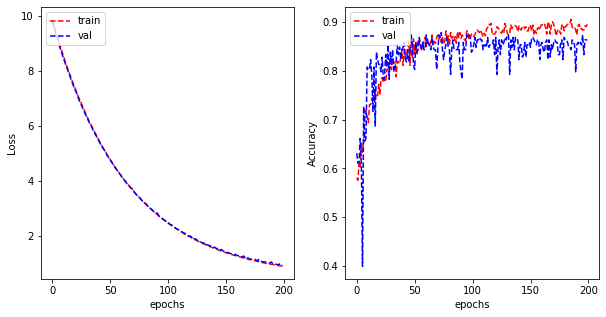

In [139]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_CV.history['loss'], 'r--')
plt.plot(history_CV.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_CV.history['categorical_accuracy'], 'r--')
plt.plot(history_CV.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

## Save model

In [140]:
# Original model without tuning
model_cancer.save("cancer_base_model")

# Model with regularization
model_cancer_reg.save("cancer_reg_base_model")

# Model with dropout
model_cancer_drop.save("cancer_dropout_base_model")
model_cancer_CV.save("cancer_CV_model")

INFO:tensorflow:Assets written to: cancer_base_model\assets
INFO:tensorflow:Assets written to: cancer_reg_base_model\assets
INFO:tensorflow:Assets written to: cancer_dropout_base_model\assets
INFO:tensorflow:Assets written to: cancer_CV_model\assets


## Testing the final model
The model tuning by dropout seems to have the best performance

In [141]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 198 validated image filenames belonging to 2 classes.


C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [142]:
model_cancer_drop.evaluate(test_generator)

198/198 [==============================] - 0s 1ms/step - loss: 0.3372 - categorical_accuracy: 0.8535


[0.3371969163417816, 0.8535353541374207]

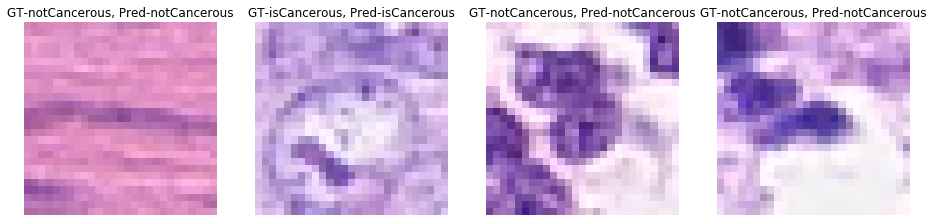

In [135]:
label_names = {'isCancerous':1,'notCancerous':0}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cancer_drop.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

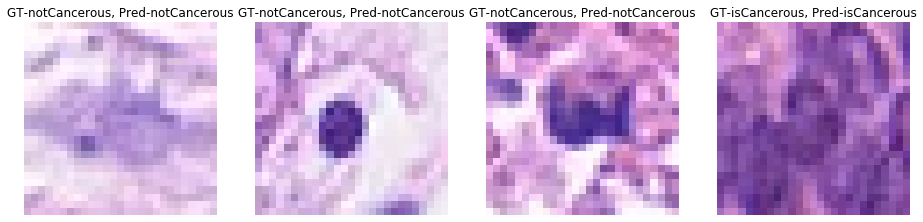

In [136]:
label_names = {'isCancerous':1,'notCancerous':0}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cancer.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

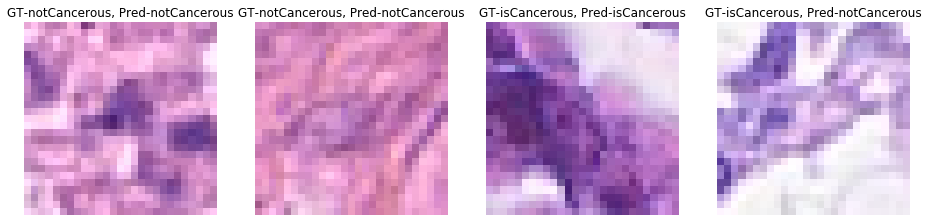

In [137]:
label_names = {'isCancerous':1,'notCancerous':0}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cancer_reg.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

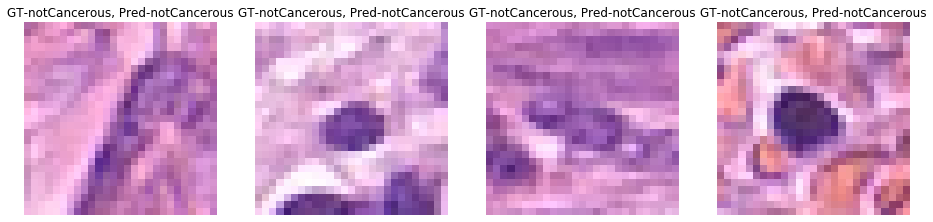

In [278]:
label_names = {'isCancerous':1,'notCancerous':0}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cancer_CV.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [143]:
model_cancer.evaluate(test_generator)

198/198 [==============================] - 0s 1ms/step - loss: 0.3864 - categorical_accuracy: 0.8535


[0.3863750100135803, 0.8535353541374207]

In [144]:
model_cancer_drop.evaluate(test_generator)

198/198 [==============================] - 0s 990us/step - loss: 0.3372 - categorical_accuracy: 0.8535


[0.33719685673713684, 0.8535353541374207]

In [145]:
model_cancer_reg.evaluate(test_generator)

198/198 [==============================] - 0s 2ms/step - loss: 1.4439 - categorical_accuracy: 0.8636


[1.4439467191696167, 0.8636363744735718]

In [146]:
model_cancer_CV.evaluate(test_generator)

198/198 [==============================] - 0s 2ms/step - loss: 9.9256 - categorical_accuracy: 0.8434


[9.925603866577148, 0.8434343338012695]

# 2nd Model (leNet)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')


Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.


In [19]:
reg_lambda = 0.001
OUTPUT_CLASSES = 2

model_cancer_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

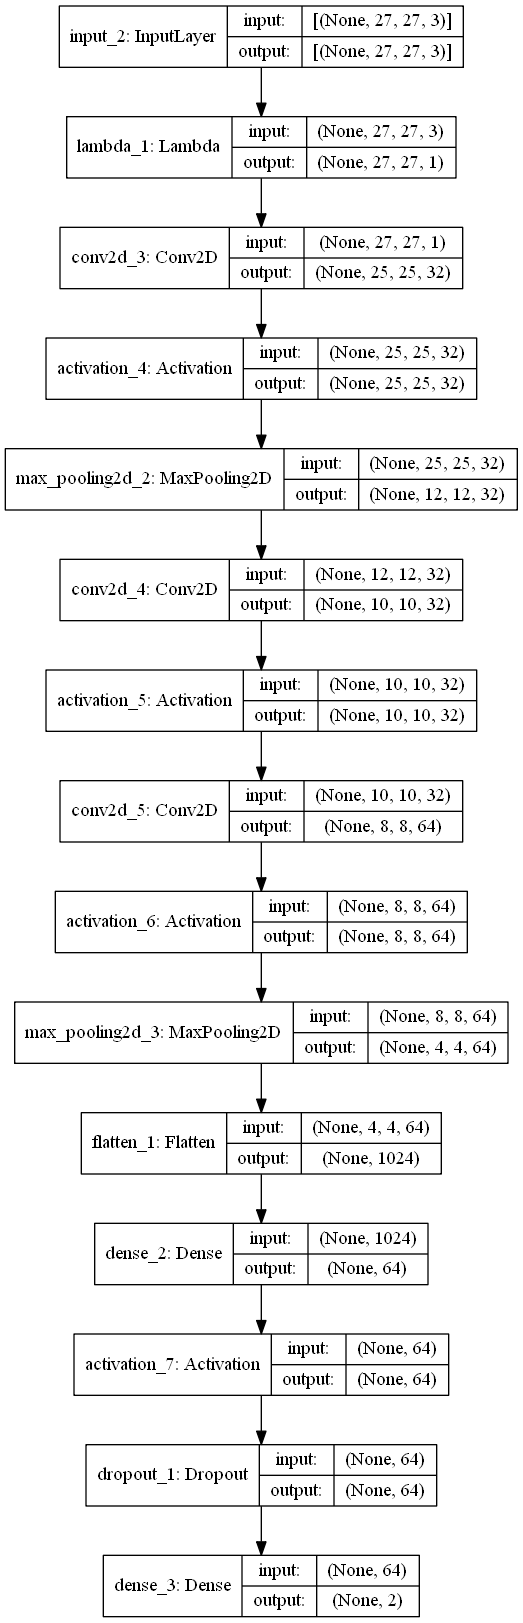

In [20]:
tf.keras.utils.plot_model(model_cancer_leNet, show_shapes=True)


In [21]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cancer_leNet.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_cancer_leNet.fit(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=100, verbose=0)

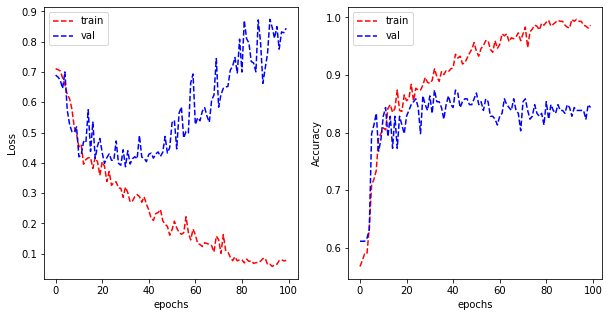

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Data augmentation

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.


In [26]:
model_leNet2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_leNet2.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet2.fit_generator(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=150, verbose=0)

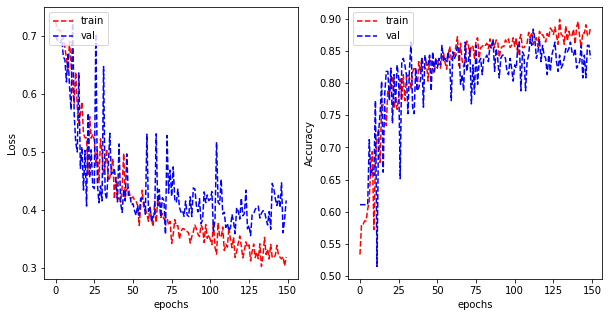

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [56]:
model_cancer_leNet.evaluate(test_generator)

7/7 [==============================] - 0s 10ms/step - loss: 0.6917 - categorical_accuracy: 0.8788


[0.6916724443435669, 0.8787878751754761]

In [57]:
model_leNet2.evaluate(test_generator)

7/7 [==============================] - 0s 10ms/step - loss: 0.4623 - categorical_accuracy: 0.8232


[0.46233195066452026, 0.8232323527336121]

In [ ]:
##

### Cross validation

In [177]:
Y = train_data[['isCancerous']]
kf = KFold(n_splits = 5)
Y

,isCancerous
7873,1
2790,1
1828,1
2370,1
6048,0
...,...
4491,0
9667,0
140,0
6924,0


In [178]:
idg_leNet = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)

In [ ]:
# VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/leNet_cancer_CV/'
fold_var = 1
reg_lambda = 0.001

for train_index, val_index in kf.split(Y):
    
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
    
    train_datagen = idg_leNet.flow_from_dataframe(dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
    valid_datagen  = idg_leNet.flow_from_dataframe(dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
       


    # CREATE NEW MODEL
    model_cancer_leNet_aug_CV = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
    # COMPILE NEW MODEL
    model_cancer_leNet_CV.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])


    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history_leNet_CV = model_cancer_leNet_CV.fit(train_datagen,
                epochs=10,
                callbacks=callbacks_list,
                validation_data= valid_datagen,
                verbose=1)
    #PLOT HISTORY
    #       :
    #       :

    # LOAD BEST MODEL to evaluate the performance of the model

    model_cancer_leNet_CV.load_weights("/leNet_cancer_CV/model_"+str(fold_var)+".h5")
    
    results = model_cancer_leNet_CV.evaluate(valid_datagen)
    results = dict(zip(model_cancer_leNet_CV.metrics_names,results))

    VALIDATION_ACCURACY.append(results['categorical_accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1
    print(fold_var)

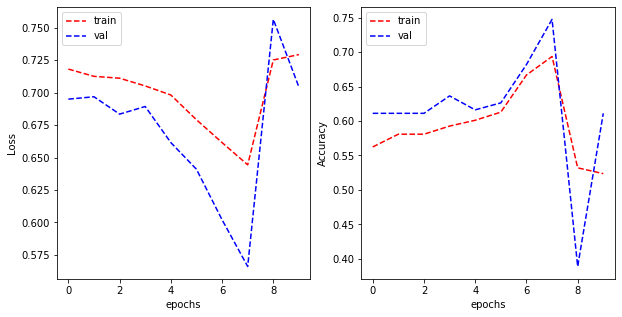

In [180]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_leNet_CV.history['loss'], 'r--')
plt.plot(history_leNet_CV.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_leNet_CV.history['categorical_accuracy'], 'r--')
plt.plot(history_leNet_CV.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

# 3rd model (VGG)

In [39]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.


C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
import tensorflow as tf

OUTPUT_CLASSES = 2
model_cancer_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [41]:
model_cancer_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [42]:
history_cancer_VGG_1 = model_cancer_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

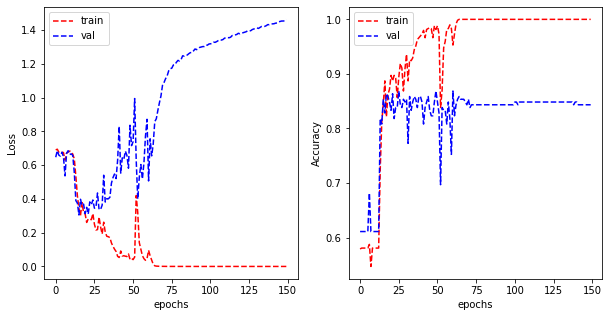

In [43]:
plot_learning_curve(history_cancer_VGG_1.history['loss'], history_cancer_VGG_1.history['val_loss'], 
                    history_cancer_VGG_1.history['categorical_accuracy'], history_cancer_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Regularization with data augmentation

In [44]:
idg_VGG1 = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)

In [45]:
batch_size = 32

train_generator = idg_VGG1.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = idg_VGG1.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 594 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.


In [46]:
OUTPUT_CLASSES = 2
model_cancer_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [47]:
model_cancer_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [48]:
history_cancer_VGG_2 = model_cancer_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

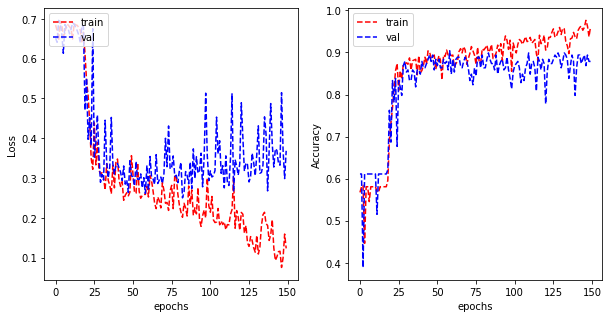

In [49]:
plot_learning_curve(history_cancer_VGG_2.history['loss'], history_cancer_VGG_2.history['val_loss'], 
                    history_cancer_VGG_2.history['categorical_accuracy'], history_cancer_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Added regulisation and drop out

In [50]:
reg_lambda = 0.001
OUTPUT_CLASSES = 2
model_cancer_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [51]:
model_cancer_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [52]:
history_cancer_VGG_3 = model_cancer_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

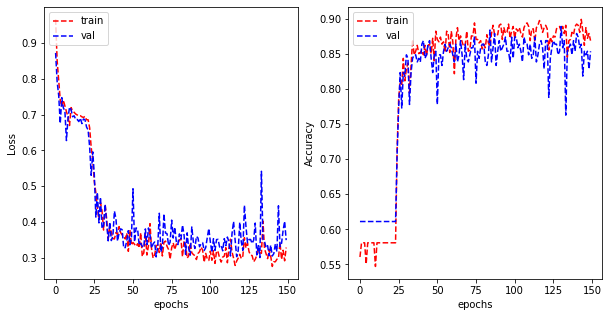

In [53]:
plot_learning_curve(history_cancer_VGG_3.history['loss'], history_cancer_VGG_3.history['val_loss'], 
                    history_cancer_VGG_3.history['categorical_accuracy'], history_cancer_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Keras tuning

In [117]:

import kerastuner as kt


def model_builder(hp):
    OUTPUT_CLASSES = 2
    # Selection ranges
    # Dense layer unit value
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    # Regularization lambda value
    hp_reg_lambdas = hp.Choice('reg_lambda', values=[0.0005, 0.001, 0.002, 0.005])
    # activation function choice
    hp_activations = hp.Choice('activation', values=['sigmoid', 'softmax'])
    # dropout value
    hp_dropouts = hp.Float('dropout', min_value=0, max_value=0.9, step=0.1)

    # initialize layers
    model = tf.keras.Sequential([
            #VGG block 1
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(hp_reg_lambdas), input_shape=(27, 27, 3)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(hp_reg_lambdas)),
            tf.keras.layers.MaxPooling2D((2, 2)),
    
            #VGG block 2
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(hp_reg_lambdas)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(hp_reg_lambdas)),
            tf.keras.layers.MaxPooling2D((2, 2)),
    
            #VGG block 3
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(hp_reg_lambdas)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(hp_reg_lambdas)),
            tf.keras.layers.MaxPooling2D((2, 2)),
    
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(hp_units, activation='relu'),
            tf.keras.layers.Dropout(hp_dropouts),
            tf.keras.layers.Dense(OUTPUT_CLASSES,activation= hp_activations )
        ])
    
    sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    # compile model
    model.compile(optimizer=sgd,
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=['categorical_accuracy'])

    return model

# Instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=150,
                     factor=3,
                     directory='keras_tuner_dir',
                     project_name='v1')

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# extracting the image and labels from the generators as search function does not support generators directly
train_img,train_lables = train_generator.next()
val_img,val_lables = validation_generator.next()

C:\Users\PC\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [118]:
# Execute search
tuner.search(train_img,train_lables,
             validation_data=(val_img,val_lables),batch_size = 32, callbacks=[stop_early])
# tuner.search(train_img,train_lables,
#              validation_data=(val_img,val_lables),batch_size = 32)

# Print optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=20)[0]

print(f"""
 units: {best_hps.get('units')}
 lamda: {best_hps.get('reg_lambda')}
 activation: {best_hps.get('activation')}
 dropout: {best_hps.get('dropout')}
""")

Trial 254 Complete [00h 00m 01s]
val_categorical_accuracy: 0.53125

Best val_categorical_accuracy So Far: 0.625
Total elapsed time: 00h 06m 08s
INFO:tensorflow:Oracle triggered exit

 units: 128
 lamda: 0.001
 activation: sigmoid
 dropout: 0.2



# Keras tuned model

In [129]:
units = 128
reg_lamda = 0.001
activation = 'sigmoid'
dropout = 0.2
OUTPUT_CLASSES = 2

model_cancer_VGG_4 = tf.keras.Sequential([
            #VGG block 1
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
            tf.keras.layers.MaxPooling2D((2, 2)),
    
            #VGG block 2
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
            tf.keras.layers.MaxPooling2D((2, 2)),
    
            #VGG block 3
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
            tf.keras.layers.MaxPooling2D((2, 2)),
    
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units, activation='relu'),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(OUTPUT_CLASSES)
        ])

In [130]:
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cancer_VGG_4.compile(optimizer=sgd,
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=['categorical_accuracy'])

C:\Users\PC\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [131]:
history_cancer_VGG_4 = model_cancer_VGG_4.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

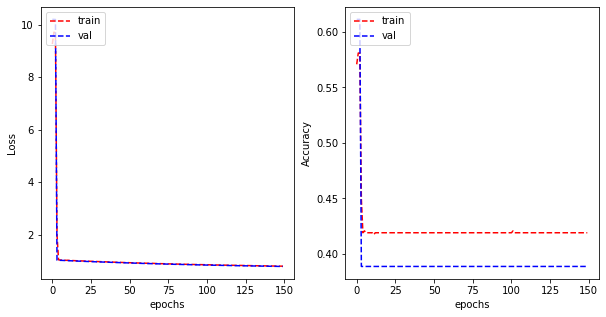

In [132]:
plot_learning_curve(history_cancer_VGG_4.history['loss'], history_cancer_VGG_4.history['val_loss'], 
                    history_cancer_VGG_4.history['categorical_accuracy'], history_cancer_VGG_4.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')